In [1]:
import pandas as pd
import numpy as np
import math
import requests
from bs4 import BeautifulSoup
from bs4 import Comment
from time import sleep
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics
from sklearn.model_selection import KFold
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures
kf = KFold(n_splits=5)
pd.set_option('display.max_columns', None)

/opt/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:


plays = pd.read_csv('MLBPlayData_201617.csv').drop('Unnamed: 0', axis=1)

In [5]:
plays.columns = ['gameID', 'date', 'stadium', 'attendance', 'inning', 'starting_pitcher', 
                 'is_starting_pitcher', 'is_away', 'batting_position', 'score', 'num_outs',
                 'runners_on_base', 'pitch_details', 'run_out_result', 'team_at_bat', 
                 'batter', 'pitcher', 'WEC%', 'wWE%', 'play_description', 'team_won']

In [6]:
plays_raw = plays.copy()

In [7]:
plays["is_single"] = ['Single' in play for play in plays['play_description']]
plays["is_double"] = ['Double' in play for play in plays['play_description']]
plays["is_triple"] = ['Triple' in play for play in plays['play_description']]
plays["is_homerun"] = ['Home Run' in play for play in plays['play_description']]
plays["is_strikeout"] = ['Strikeout' in play for play in plays['play_description']]
plays["is_groundout"] = ['Groundout' in play for play in plays['play_description']]
plays["is_walk"] = ['Walk' in play for play in plays['play_description']]
plays["is_steal"] = [('Steal' or 'Steals' or 'steal' or 'steals') in play for play in plays['play_description']]

In [8]:
plays['runner_on_first']= [0 if runner[0]=='-' else 1 for runner in plays['runners_on_base']]
plays['runner_on_second']= [0 if runner[1]=='-' else 1 for runner in plays['runners_on_base']]
plays['runner_on_third']= [0 if runner[2]=='-' else 1 for runner in plays['runners_on_base']]

In [9]:
plays['runs_in_atbat'] = [0 if type(row)==float else row.count('R') for row in plays['run_out_result']]
plays['outs_in_atbat'] = [0 if type(row)==float else row.count('O') for row in plays['run_out_result']]

In [10]:
plays['batting_team_runs'] = [score.split('-')[0] for score in plays['score']]
plays['fielding_team_runs'] = [score.split('-')[1] for score in plays['score']]

In [11]:
plays["pitch_count"] = [pitch.split(',')[0] if isinstance(pitch,str) else None for pitch in plays['pitch_details']]
plays["ball_count"] = [pitch.split('(')[1].split('-')[0] if isinstance(pitch,str) else None for pitch in plays['pitch_details']]
plays["strike_count"] = [pitch.split('(')[1].split('-')[1].split(')')[0] if isinstance(pitch,str) else None for pitch in plays['pitch_details']]

In [12]:
plays['date'] = pd.to_datetime(plays['date'])

In [13]:
plays['home_team_won'] = np.where(plays['team_won'] == plays['is_away'], 0, 1)

In [14]:
# plays['wWE%'] = plays['wWE%'].apply(lambda x: int(x.replace('%','')))
# plays['WEC%'] = plays['WEC%'].apply(lambda x: int(x.replace('%','')))

In [15]:
plays.head()

,gameID,date,stadium,attendance,inning,starting_pitcher,is_starting_pitcher,is_away,batting_position,score,num_outs,runners_on_base,pitch_details,run_out_result,team_at_bat,batter,pitcher,WEC%,wWE%,play_description,team_won,is_single,is_double,is_triple,is_homerun,is_strikeout,is_groundout,is_walk,is_steal,runner_on_first,runner_on_second,runner_on_third,runs_in_atbat,outs_in_atbat,batting_team_runs,fielding_team_runs,pitch_count,ball_count,strike_count,home_team_won
0,1,2006-09-08,Angel Stadium of Anaheim,"42,259",1,Joe Saunders,1,1,1,0-0,0,---,"5,(1-2) CFBFX",NaN,TOR,Reed Johnson,Joe Saunders,-6%,44%,Double to CF (Fly Ball to Deep CF),0,False,True,False,False,False,False,False,False,0,0,0,0,0,0,0,5,1,2,1
1,1,2006-09-08,Angel Stadium of Anaheim,"42,259",1,Joe Saunders,1,1,2,0-0,0,-2-,"6,(3-2) FBFBBX",O,TOR,Aaron Hill,Joe Saunders,4%,48%,Lineout: 3B,0,False,False,False,False,False,False,False,False,0,1,0,0,1,0,0,6,3,2,1
2,1,2006-09-08,Angel Stadium of Anaheim,"42,259",1,Joe Saunders,1,1,3,0-0,1,-2-,"2,(1-0) *BX",RO,TOR,Vernon Wells,Joe Saunders,-4%,44%,Single to RF (Line Drive); Johnson Scores; out...,0,True,False,False,False,False,False,False,False,0,1,0,1,1,0,0,2,1,0,1
3,1,2006-09-08,Angel Stadium of Anaheim,"42,259",1,Joe Saunders,1,1,4,1-0,2,---,"2,(0-1) CX",O,TOR,Troy Glaus,Joe Saunders,1%,45%,Lineout: 3B-1B,0,False,False,False,False,False,False,False,False,0,0,0,0,1,1,0,2,0,1,1
4,1,2006-09-08,Angel Stadium of Anaheim,"42,259",1,A.J. Burnett,1,0,1,0-1,0,---,"4,(1-2) BCCX",NaN,LAA,Maicer Izturis,A.J. Burnett,4%,49%,Single to 1B (Ground Ball),1,True,False,False,False,False,False,False,False,0,0,0,0,0,0,1,4,1,2,1


In [16]:
plays_first_play = plays.drop_duplicates(subset='gameID', keep='first')
plays_last_play = plays.drop_duplicates(subset='gameID', keep='last')

In [17]:
plays_last_play

,gameID,date,stadium,attendance,inning,starting_pitcher,is_starting_pitcher,is_away,batting_position,score,num_outs,runners_on_base,pitch_details,run_out_result,team_at_bat,batter,pitcher,WEC%,wWE%,play_description,team_won,is_single,is_double,is_triple,is_homerun,is_strikeout,is_groundout,is_walk,is_steal,runner_on_first,runner_on_second,runner_on_third,runs_in_atbat,outs_in_atbat,batting_team_runs,fielding_team_runs,pitch_count,ball_count,strike_count,home_team_won
63,1,2006-09-08,Angel Stadium of Anaheim,"42,259",9,Joe Saunders,0,1,4,1-4,2,---,"4,(2-1) CBBX",O,TOR,Troy Glaus,Francisco Rodriguez,0%,100%,Popfly: 1B,0,False,False,False,False,False,False,False,False,0,0,0,0,1,1,4,4,2,1,1
141,2,2006-09-08,Chase Field,"25,299",9,Livan Hernandez,0,1,6,1-13,2,---,"1,(0-0) X",O,STL,Mike Rose,Randy Choate,0%,100%,Lineout: 1B,0,False,False,False,False,False,False,False,False,0,0,0,0,1,1,13,1,0,0,1
217,3,2006-09-08,Turner Field,"30,977",9,Tim Hudson,0,1,9,4-8,2,---,"3,(0-2) .CCX",O,CHC,Freddie Bynum,Bob Wickman,0%,100%,Groundout: 2B-1B,0,False,False,False,False,False,True,False,False,0,0,0,0,1,4,8,3,0,2,1
292,4,2006-09-08,Oriole Park at Camden Yards,"36,214",9,Erik Bedard,0,1,1,4-9,2,1--,"1,(0-0) .X",O,NYY,Kevin Thompson,Julio Manon,0%,100%,Lineout: LF,0,False,False,False,False,False,False,False,False,1,0,0,0,1,4,9,1,0,0,1
383,5,2006-09-08,Fenway Park,"36,531",9,Odalis Perez,0,0,9,9-10,2,---,"6,(3-2) .BBCBFX",O,BOS,Trot Nixon,Joe Nelson,5%,100%,Flyball: RF,0,False,False,False,False,False,False,False,False,0,0,0,0,1,9,10,6,3,2,0
473,6,2006-09-08,U.S. Cellular Field,"37,188",9,Paul Byrd,0,0,1,5-6,0,1--,"4,(0-2) .MSFX",RR,CHW,A.J. Pierzynski,Tom Mastny,64%,100%,Home Run (Fly Ball); Iguchi Scores,1,False,False,False,True,False,False,False,False,1,0,0,2,0,5,6,4,0,2,1
554,7,2006-09-08,Great American Ball Park,"17,631",9,Kyle Lohse,0,1,1,1-9,2,12-,"2,(1-0) .BX",O,PIT,Rajai Davis,Gary Majewski,0%,100%,Groundout: 2B-1B,0,False,False,False,False,False,True,False,False,1,1,0,0,1,1,9,2,1,0,1
644,8,2006-09-08,Coors Field,"22,214",9,Byung-Hyun Kim,0,1,8,8-11,2,-23,"2,(0-1) CX",O,WSN,Jose Vidro,Brian Fuentes,5%,100%,Groundout: 2B-1B,0,False,False,False,False,False,True,False,False,0,1,1,0,1,8,11,2,0,1,1
714,9,2006-09-08,Dolphins Stadium,"21,432",9,Jamie Moyer,0,0,6,2-3,2,---,"4,(1-2) CBCS",O,FLA,Joe Borchard,Tom Gordon,5%,100%,Strikeout Swinging,0,False,False,False,False,True,False,False,False,0,0,0,0,1,2,3,4,1,2,0
787,10,2006-09-08,Miller Park,"19,677",9,Roy Oswalt,0,0,7,3-4,2,1--,"5,(2-2) .SBCBS",O,MIL,Gabe Gross,Brad Lidge,10%,100%,Strikeout Swinging,0,False,False,False,False,True,False,False,False,1,0,0,0,1,3,4,5,2,2,0


In [18]:
# by_home_away = plays_last_play.groupby('home_team_won').size()

# fig, ax = plt.subplots(figsize=(10,6))
# ax.bar([0,1], by_home_away)
# ax.set_xticks([0,1])
# ax.set_xticklabels(['Away', 'Home'])
# ax.set_title('Games Won by Home/Away Teams')
# ax.set_ylabel('Number of Games')
# plt.show()

In [19]:
# win_prob_by_score = pd.pivot_table(plays, values='wWE%', index=['fielding_team_runs'], columns=['batting_team_runs'])
# win_prob_by_score
# fig, ax = plt.subplots(figsize=(15,10))
# sns.heatmap(win_prob_by_score)
# plt.show()

In [20]:
np.random.seed(9001)
msk = np.random.rand(len(plays)) < 0.75
plays_train = plays[msk]
plays_test = plays[~msk]

In [21]:
plays_train = plays_train.drop(['stadium', 'starting_pitcher', 'score', 
                                'runners_on_base', 'pitch_details',
                                'play_description', 'run_out_result'],axis=1)
plays_test = plays_test.drop(['stadium', 'starting_pitcher', 'score', 
                              'runners_on_base', 'pitch_details', 
                              'play_description', 'run_out_result'],axis=1)
plays_all = plays.drop(['stadium', 'starting_pitcher', 'score', 
                              'runners_on_base', 'pitch_details', 
                              'play_description', 'run_out_result'],axis=1)

In [22]:
plays_train['attendance'] = plays_train['attendance'].apply(lambda x: int(x.replace(',','')) if type(x)==str else 0)
plays_test['attendance'] = plays_test['attendance'].apply(lambda x: int(x.replace(',','')) if type(x)==str else 0)
plays_all['attendance'] = plays_all['attendance'].apply(lambda x: int(x.replace(',','')) if type(x)==str else 0)


for col in ['batting_team_runs', 'fielding_team_runs', 'pitch_count', 'strike_count', 'ball_count']:
    plays_train[col] = plays_train[col].apply(lambda x: int(float(x)) if type(x)==str and len(x) > 0 else -1)
    plays_test[col] = plays_test[col].apply(lambda x: int(float(x)) if type(x)==str and len(x) > 0 else -1)
    plays_all[col] = plays_all[col].apply(lambda x: int(float(x)) if type(x)==str and len(x) > 0 else -1)

plays_train['run_diff'] = plays_train['batting_team_runs'] - plays_train['fielding_team_runs']
plays_test['run_diff'] = plays_test['batting_team_runs'] - plays_test['fielding_team_runs']
plays_all['run_diff'] = plays_all['batting_team_runs'] - plays_all['fielding_team_runs']

plays_train['run_scored'] = plays_train['batting_team_runs'] + plays_train['fielding_team_runs']
plays_test['run_scored'] = plays_test['batting_team_runs'] + plays_test['fielding_team_runs']
plays_all['run_scored'] = plays_all['batting_team_runs'] + plays_all['fielding_team_runs']

for col in ['is_single', 'is_double', 'is_triple', 'is_homerun', 'is_strikeout', 'is_groundout',
            'is_walk', 'is_steal']:
    plays_train[col] = plays_train[col].astype(int)
    plays_test[col] = plays_test[col].astype(int)
    plays_all[col] = plays_all[col].astype(int)

In [23]:
plays_train.columns

Index(['gameID', 'date', 'attendance', 'inning', 'is_starting_pitcher',
       'is_away', 'batting_position', 'num_outs', 'team_at_bat', 'batter',
       'pitcher', 'WEC%', 'wWE%', 'team_won', 'is_single', 'is_double',
       'is_triple', 'is_homerun', 'is_strikeout', 'is_groundout', 'is_walk',
       'is_steal', 'runner_on_first', 'runner_on_second', 'runner_on_third',
       'runs_in_atbat', 'outs_in_atbat', 'batting_team_runs',
       'fielding_team_runs', 'pitch_count', 'ball_count', 'strike_count',
       'home_team_won', 'run_diff', 'run_scored'],
      dtype='object')

In [24]:
X_train = plays_train.drop(['gameID', 'home_team_won', 'team_won', 'WEC%', 'wWE%', 'team_at_bat', 'batter', 'pitcher', 'date', 'pitch_count'], axis=1).values
X_test = plays_test.drop(['gameID', 'home_team_won', 'team_won', 'WEC%', 'wWE%', 'team_at_bat', 'batter', 'pitcher', 'date', 'pitch_count'], axis=1).values
X_all = plays_all.drop(['gameID', 'home_team_won', 'team_won', 'WEC%', 'wWE%', 'team_at_bat', 'batter', 'pitcher', 'date', 'pitch_count'], axis=1).values
y_train = plays_train['team_won'].values
y_test = plays_test['team_won'].values
y_all = plays_all['team_won'].values

In [25]:
plays_train.head()

,gameID,date,attendance,inning,is_starting_pitcher,is_away,batting_position,num_outs,team_at_bat,batter,pitcher,WEC%,wWE%,team_won,is_single,is_double,is_triple,is_homerun,is_strikeout,is_groundout,is_walk,is_steal,runner_on_first,runner_on_second,runner_on_third,runs_in_atbat,outs_in_atbat,batting_team_runs,fielding_team_runs,pitch_count,ball_count,strike_count,home_team_won,run_diff,run_scored
0,1,2006-09-08,42259,1,1,1,1,0,TOR,Reed Johnson,Joe Saunders,-6%,44%,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,5,1,2,1,0,0
3,1,2006-09-08,42259,1,1,1,4,2,TOR,Troy Glaus,Joe Saunders,1%,45%,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,2,0,1,1,1,1
5,1,2006-09-08,42259,1,1,0,2,0,LAA,Orlando Cabrera,A.J. Burnett,6%,55%,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,4,1,2,1,-1,1
6,1,2006-09-08,42259,1,1,0,3,0,LAA,Vladimir Guerrero,A.J. Burnett,-11%,44%,1,0,1,0,0,0,0,0,0,1,1,0,0,2,0,1,1,0,0,1,-1,1
9,1,2006-09-08,42259,2,1,1,6,1,TOR,Alex Rios,Joe Saunders,-4%,39%,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,5,2,2,1,1,1


In [26]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((477853, 25), (477853,), (158938, 25), (158938,))

In [29]:
def bin_accuracy(n_bins, preds, actual_outcomes):
    bin_size = int(100/n_bins)
    bins = list(range(0,100,bin_size))
    for i in range(len(bins)):
        bins[i] += bin_size/2.
    bin_win_pct = []
    correct_win_pct = []
    for i in range(0,100,bin_size):
        pct = float(i)/100
        in_bin = [pred > pct and pred <= (pct + bin_size/100.) for pred in preds]
        num_in_bin = np.sum(in_bin)
        wins_in_bin = in_bin * actual_outcomes
        num_correct = np.sum(wins_in_bin)
        if num_in_bin != 0:
            bin_win_pct.append(float(num_correct)/num_in_bin)
            correct_win_pct.append(pct + bin_size/200.)
    #plt.bar(bins,bin_win_pct,width = bin_size)
    #plt.show()
    return metrics.r2_score(correct_win_pct,bin_win_pct)

def bin_accuracy_plot(n_bins, preds, actual_outcomes):
    bin_size = int(100/n_bins)
    bins = list(range(0,100,bin_size))
    for i in range(len(bins)):
        bins[i] += bin_size/2.
    bin_win_pct = []
    correct_win_pct = []
    for i in range(0,100,bin_size):
        pct = float(i)/100
        in_bin = [pred > pct and pred < (pct + bin_size/100.) for pred in preds]
        num_in_bin = np.sum(in_bin)
        wins_in_bin = in_bin * actual_outcomes
        num_correct = np.sum(wins_in_bin)
        bin_win_pct.append(float(num_correct)/num_in_bin)
        correct_win_pct.append(pct + bin_size/200.)
    print(bin_win_pct)
    plt.bar(bins,bin_win_pct,width = bin_size)
    plt.show()
    return metrics.r2_score(correct_win_pct,bin_win_pct)

In [30]:
cross_val_scores = []
trees = [2**x for x in range(7)]
for md in [1,2,5,10,None]:
    for tree in trees:
        rf = RandomForest(max_depth = md, n_estimators=tree, max_features='sqrt')
        cv_scores = []
        for train_index, val_index in kf.split(X_train):
            rf.fit(X_train[train_index],y_train[train_index])
            preds = rf.predict_proba(X_train[val_index])
            acc = bin_accuracy(20, [pred[1] for pred in preds], y_train[val_index])
            cv_scores.append(acc)
        cv_score = cross_val_score(rf, X_train, y_train, cv = 5)
        cross_val_scores.append((np.mean(cv_scores), np.mean(cv_score), tree, md))
cross_val_scores

[(0.98179837908244472, 0.60388409300640666, 1, 1),
 (0.05560639077927134, 0.64455611444828897, 2, 1),
 (-4.4375984417700476, 0.7052397949945145, 4, 1),
 (-6.9727408623086387, 0.70670276297606027, 8, 1),
 (-7.016827978832465, 0.73565303195664788, 16, 1),
 (-6.397031487720521, 0.73142371553220964, 32, 1),
 (-5.5402083279135912, 0.73581835407318963, 64, 1),
 (0.99453403040859423, 0.68140836324499432, 1, 2),
 (0.34346396400341306, 0.68532154177037119, 2, 2),
 (-0.42468337686022706, 0.71538532707033897, 4, 2),
 (0.20691643770329654, 0.73319828626198369, 8, 2),
 (-0.051206441954509477, 0.73024971932384974, 16, 2),
 (0.037328618649659126, 0.73602553339362264, 32, 2),
 (-0.29380479910605378, 0.73648174041393677, 64, 2),
 (0.99146454716086152, 0.72592199528961499, 1, 5),
 (0.96648792780899484, 0.73764946320937708, 2, 5),
 (0.96337895462853251, 0.73954126441533197, 4, 5),
 (0.93816235205660659, 0.74482949840044754, 8, 5),
 (0.934205398059478, 0.74588002536057485, 16, 5),
 (0.92987685218079896, 0

In [31]:
cross_val_scores

[(0.98179837908244472, 0.60388409300640666, 1, 1),
 (0.05560639077927134, 0.64455611444828897, 2, 1),
 (-4.4375984417700476, 0.7052397949945145, 4, 1),
 (-6.9727408623086387, 0.70670276297606027, 8, 1),
 (-7.016827978832465, 0.73565303195664788, 16, 1),
 (-6.397031487720521, 0.73142371553220964, 32, 1),
 (-5.5402083279135912, 0.73581835407318963, 64, 1),
 (0.99453403040859423, 0.68140836324499432, 1, 2),
 (0.34346396400341306, 0.68532154177037119, 2, 2),
 (-0.42468337686022706, 0.71538532707033897, 4, 2),
 (0.20691643770329654, 0.73319828626198369, 8, 2),
 (-0.051206441954509477, 0.73024971932384974, 16, 2),
 (0.037328618649659126, 0.73602553339362264, 32, 2),
 (-0.29380479910605378, 0.73648174041393677, 64, 2),
 (0.99146454716086152, 0.72592199528961499, 1, 5),
 (0.96648792780899484, 0.73764946320937708, 2, 5),
 (0.96337895462853251, 0.73954126441533197, 4, 5),
 (0.93816235205660659, 0.74482949840044754, 8, 5),
 (0.934205398059478, 0.74588002536057485, 16, 5),
 (0.92987685218079896, 0

[0.0093329673346143286, 0.051321727917472595, 0.09760675739089629, 0.15107438016528926, 0.20517498756012606, 0.28171364985163205, 0.32817460317460317, 0.37931828650391525, 0.41371055495103376, 0.45656747820859633, 0.53557005281143211, 0.56969082615306643, 0.63264221158958001, 0.68600773642790447, 0.74529600734281776, 0.80286021836075661, 0.84281763935380583, 0.90019774339886005, 0.95237229594619155, 0.98549323017408119]


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


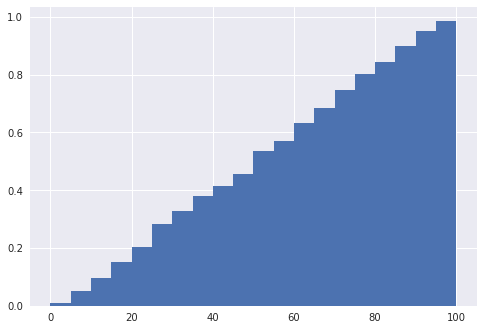

0.99616100298047028

In [32]:
rf = RandomForest(max_depth = 10, n_estimators=10, max_features='sqrt')
rf.fit(X_train,y_train)
rf_test_preds = rf.predict_proba(X_test)
bin_accuracy_plot(20,[pred[1] for pred in rf_test_preds],y_test)

In [33]:
Cs = [10**x for x in range(6)]
cross_val_scores = []
for c in Cs:
    logit = LogisticRegression(C = c)
    cv_scores = []
    for train_index, val_index in kf.split(X_train):
        logit.fit(X_train[train_index],y_train[train_index])
        preds = logit.predict_proba(X_train[val_index])
        acc = bin_accuracy(20, [pred[1] for pred in preds], y_train[val_index])
        cv_scores.append(acc)
    cv_score = cross_val_score(logit, X_train, y_train, cv = 5)
    cross_val_scores.append((np.mean(cv_scores), np.mean(cv_score), c))
cross_val_scores

[(0.99720509256446732, 0.75253269799267242, 1),
 (0.99720300192763534, 0.75253688342840197, 10),
 (0.99719727540799319, 0.75253688342840197, 100),
 (0.99719727540799319, 0.75253688342840197, 1000),
 (0.997197014704434, 0.75253897613531839, 10000),
 (0.99719673786001495, 0.75253688342840197, 100000)]

[0.018558295386201563, 0.073600888765449249, 0.11413307430791647, 0.16100052844812401, 0.21725888324873097, 0.254892447032185, 0.32979397781299524, 0.38286101388732074, 0.43115519253208867, 0.47774315602047629, 0.54365119323330979, 0.58647414799872599, 0.63795954713140823, 0.70569715142428791, 0.73722214356505733, 0.78240814378877044, 0.82972181551976576, 0.87626299604627322, 0.91533605644262905, 0.97175362887406824]


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


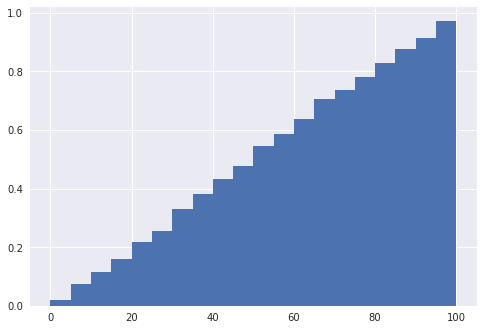

0.99827138234362223

In [34]:
logit = LogisticRegression(C = 10000)
logit.fit(X_train, y_train)
logit_test_preds = logit.predict_proba(X_test)
bin_accuracy_plot(20,[pred[1] for pred in logit_test_preds],y_test)

In [35]:
logit_test_preds

array([[ 0.51415086,  0.48584914],
       [ 0.44273186,  0.55726814],
       [ 0.54295645,  0.45704355],
       ..., 
       [ 0.04601105,  0.95398895],
       [ 0.06334962,  0.93665038],
       [ 0.94990885,  0.05009115]])

In [36]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

lda_train_preds = lda.predict_proba(X_train)
lda_test_preds = lda.predict_proba(X_test)

/opt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [37]:
lda.predict_proba(X_test)

array([[ 0.50492695,  0.49507305],
       [ 0.45668425,  0.54331575],
       [ 0.50603819,  0.49396181],
       ..., 
       [ 0.11204116,  0.88795884],
       [ 0.14868698,  0.85131302],
       [ 0.89643832,  0.10356168]])

[0.0035056967572304996, 0.033513702216791764, 0.065573770491803282, 0.097457627118644072, 0.14311068086479509, 0.19990563070147846, 0.25514735567218411, 0.33896563534650076, 0.40440748440748442, 0.468932779520217, 0.53802177147779784, 0.60324171952078931, 0.67525298988040483, 0.7321850726106045, 0.78026666666666666, 0.83745484856904695, 0.88343920815482346, 0.91982665222101845, 0.95314445828144456, 0.98671667448038758]


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


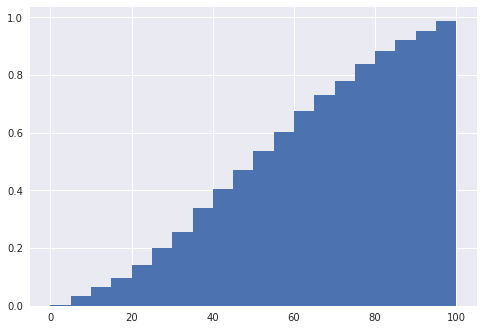

0.96945395515796706

In [38]:
bin_accuracy_plot(20,[pred[1] for pred in lda_test_preds],y_test)

In [39]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

qda_train_preds = qda.predict_proba(X_train)
qda_test_preds = qda.predict_proba(X_test)

/opt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


[0.15309428808612055, 0.39751552795031053, 0.45277973258268822, 0.48874244920373422, 0.52080964293836707, 0.54026666666666667, 0.5611015490533563, 0.56571994715984153, 0.59992987377279106, 0.57675696898311735, 0.60124740124740128, 0.61883036084612197, 0.60721649484536078, 0.6145699614890886, 0.62448330683624798, 0.64618055555555554, 0.64909983633387891, 0.63853538736325077, 0.6598500340831629, 0.74966641250476551]


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


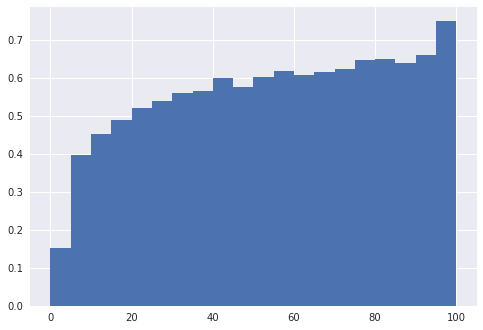

0.48055458928412398

In [40]:
bin_accuracy_plot(20,[pred[1] for pred in qda_test_preds],y_test)

In [41]:
Ks = [x for x in range(0,105,5)]
cross_val_scores = []
for k in Ks:
    knn = KNeighborsClassifier(n_neighbors = k)
    cv_scores = []
    for train_index, val_index in kf.split(X_train):
        knn.fit(X_train, y_train)
        preds = knn.predict_proba(X_train[val_index])
        acc = bin_accuracy(20, [pred[1] for pred in preds], y_train[val_index])
        cv_scores.append(acc)
    cv_score = cross_val_score(knn, X_train, y_train, cv = 5)
    cross_val_scores.append((np.mean(cv_scores), np.mean(cv_score), k))
cross_val_scores


ValueError: Expected n_neighbors > 0. Got 0

In [ ]:
knn = KNeighborsClassifier(n_neighbors = k)
knn.fit(X_train, y_train)
knn_test_preds = knn.predict_proba(X_test)

In [ ]:
bin_accuracy_plot(20,[pred[1] for pred in knn_test_preds],y_test)

In [ ]:
cross_val_scores = []
trees = [2**x for x in range(7)]
for md in [1,2,5,10,None]:
    for tree in trees:
        ada=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=md),n_estimators=tree, learning_rate=.05)
        cv_scores = []
        for train_index, val_index in kf.split(X_train):
            ada.fit(X_train[train_index],y_train[train_index])
            preds = rf.predict_proba(X_train[val_index])
            acc = bin_accuracy(20, [pred[1] for pred in preds], y_train[val_index])
            cv_scores.append(acc)
        cv_score = cross_val_score(ada, X_train, y_train, cv = 5)
        cross_val_scores.append((np.mean(cv_scores), np.mean(cv_score), tree, md))
cross_val_scores

In [ ]:
cross_val_scores

In [ ]:
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),n_estimators=10, learning_rate=.05)
ada.fit(X_train,y_train)
ada_test_preds = ada.predict_proba(X_test)
bin_accuracy_plot(20,[pred[1] for pred in ada_test_preds],y_test)

In [ ]:
logit_all_preds = logit.predict_proba(X_all)
print(pd.DataFrame(logit_all_preds).describe())
plays_all['logitWP'] = [pred[1] for pred in logit_all_preds]
plays.head()

In [ ]:
wPC = [plays_all['logitWP'][i]-plays_all['logitWP'][i-1] if plays_all['is_away'][i] == plays_all['is_away'][i-1] else plays_all['logitWP'][i]-(1-plays_all['logitWP'][i-1]) for i in range(1,len(plays_all['logitWP']),1)]
wPC = [plays_all['logitWP'][i]-.50 if plays_all['gameID'][i] != plays_all['gameID'][i-1] else wPC[i-1] for i in range(1,len(wPC)+1,1)]

In [ ]:
wPC = [plays_all['logitWP'][0]-.50] + wPC
print(len(wPC))
print(len(plays_all['logitWP']))

In [ ]:
plays_all['wPC'] = wPC
plays_all

In [ ]:
plays_all['outs_left'] = [(9 - plays_all['inning'][i]) * 6 + plays_all['is_away'][i] * 3 + 3 - plays_all['num_outs'][i] if plays_all['inning'][i] <= 9 else plays_all['is_away'][i] * 3 + 3 - plays_all['num_outs'][i] for i in range(len(plays_all['is_away']))]

In [ ]:
plays_all['wPCAbs'] = abs(plays_all['wPC'])
plays_all['rdAbs'] = abs(plays_all['run_diff'])

In [ ]:
plays_all.head()

In [ ]:
lev_Train = plays_all[["wPCAbs",'outs_left','rdAbs']][msk]
lev_Test = plays_all[["wPCAbs",'outs_left','rdAbs']][~msk]
lev_Train['runsXouts'] = lev_Train['rdAbs'] / lev_Train['outs_left']
lev_Test['runsXouts'] = lev_Test['rdAbs'] / lev_Test['outs_left']
lev_Train['inv_rd'] = 1 / (lev_Train['rdAbs'] + 1)
lev_Test['inv_rd'] = 1 / (lev_Test['rdAbs'] + 1)
lev_Train['inv_outs'] = 1 / (lev_Train['outs_left'] + 1)
lev_Test['inv_outs'] = 1 / (lev_Test['outs_left'] + 1)

In [ ]:
linLevReg = OLS(100*lev_Train["wPCAbs"], lev_Train[['outs_left','rdAbs','runsXouts','inv_rd', 'inv_outs']],interaction = True)
results = linLevReg.fit()
print(metrics.r2_score(100*lev_Test["wPCAbs"],results.predict(lev_Test[['outs_left','rdAbs','runsXouts','inv_rd', 'inv_outs']])))
results.summary()